# Разработка алгоритма сервиса упаковщика для Яндекс Маркета

<font size=3><b>Общее описание задачи:</b></font> 

Для того, чтобы пользователь получил заказ, необходимо упаковать заказанные товары в посылки конечному клиенту. Компания заметила, что сотрудник тратит большое количество времени для выбора упаковочного материала в который необходимо упаковать товары. Существует большое количество упаковочного материала (коробочки, пакетики). Необходимо придумать способ подсказывать пользователю информацию о выборе упаковочного материала. Интерфейс упаковщика должен отображать содержимое заказа для контроля комплектности. Интерфейс упаковщика должен на основании содержимого заказа, подсказывать упаковщику в какую тару (коробку, пакет, с учетом размера) нужно упаковать заказ. При определении варианта упаковки (тары) для заказа нужно учитывать тип товара, весогабаритные характеристики и необходимость в дополнительной упаковке для хрупких товаров.


<font size=3><b>Цели сервиса:</b></font>  

 - С высокой точностью рекомендовать правильную упаковку для заказа,
которая позволит доставить товары без порчи клиенту и минимизирует затраты
на упаковочный материал,
 - Отображение статистики о работе модели,
 - Интерфейс о том, как советовать информацию по выбору коробки
пользователю.

<font size=3><b>Цель DS:</b></font>

- Необходимо разработать классификационную модель, которая позволит
подсказывать, а какой заказ упаковывать в коробки, а какие в пакетики.

- При этом заказ может упаковываться в различные посылки и наша задача
минимизировать их колличество.

- Выводить оценку качества модели.


**План:**
 - Загрузить и изучить файлы
 - Сделать предварительные выводы
 - подготовить данные для обучения моделей
 - Подобрать наилучшие модель для предсказания
 - Сделать обобщающие выводы и предоставить отчёт о результатах работы.

## Exploratory data analysis

**Содержание**:

 * [Заказы (data)](#1)
 * [SKU (sku)](#2)
 * [Карготипы товаров (sku_cargotypes)](#3)
 * [Описание карготипов (cargotype_info)](#4)
 * [Характеристики упаковок (carton)](#5)
 * [Стоимость упаковок (carton_price)](#6)
 * [Анализ и подготовка данных](#7)
 * [One order - one box:](#8)
    * [Dimentions](#9)
    * [Weight](#10)
    * [box/package/none](#11)
 
 * [one box - two or three sku:](#12)
    * [Dimentions](#13)
    * [Weight](#14)
    * [box/package/none](#15)
 * [Вывод](#16)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(10,6)}, style="darkgrid")

pd.options.display.max_colwidth = 100
pd.options.display.max_columns = 100
pd.options.display.max_rows=100

In [2]:
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"
from io import StringIO  
from io import BytesIO
from urllib.parse import urlencode

## Exploratory data analysis

### Заказы (data) <a id='1'>

Для начала, загрузим наборы данных и генерируем простой предварительный просмотр и статистику

Информация по заказам и товарам (sku), которые в них содержатся

- whs - код сортировочного центра;
- orderkey - id заказа;
- selected_cartontype - код упаковки, которая была выбрана пользователем;
- box_num - количество коробок;
- recommended_cartontype - код упаковки, рекомендованной алгоритмом;
- selected_carton - код упаковки, которая была выбрана пользователем (дубль);
- sel_calc_cube - объём выбранной упаковки;
- recommended_carton - код упаковки, рекомендованной алгоритмом (дубль);
- pack_volume - рассчитанный объём упакованных товаров;
- rec_calc_cube - рекомендованный объём выбранной упаковки
- goods_wght - вес товара;
- sku - id товара;
- who - упаковщик;
- trackingid - id доставки;

In [3]:
data = pd.read_csv('data.csv', index_col=0)

In [4]:
data.sample(5)
data.info()
data[['box_num', 'sel_calc_cube', 'pack_volume', 'rec_calc_cube', 'goods_wght']].describe()
data.nunique()
data.duplicated().sum()

,whs,orderkey,selected_cartontype,box_num,recommended_cartontype,selected_carton,sel_calc_cube,recommended_carton,pack_volume,rec_calc_cube,goods_wght,sku,who,trackingid
310011,7,18a7f416976e5157a0203d04b8f2f239,YMC,1,YMF,YMC,8525,YMF,1056,13500,0.110,c4a1be6b4cb409223036537c3d122893,82cbc398a26d31ceebc1fae91c764618,6ed00915b729eb5474ae1cac76adf105
105351,0,c6f08cf222f425f397a9f1beaac0e485,NONPACK,62,YML,NONPACK,0,YML,14681,108000,0.175,c4a07062aac4a106f376ca2ee4e18231,c93fe8c2ddf662ced8091236545e15cd,8344ba39551c79744bae77b6e3e7a99c
94519,0,dbde17e0f5ddf7b4e7c4b3ce588494ee,YMC,1,MYB,YMC,9000,MYB,467,3449,0.290,7b01ab4ed6a39d5f8932a9ea774ddb0f,2310d9f42adf2d66fb086d4c73d427e4,8bf1d88482e43c4766d49bd3edb4a226
266113,4,5db034e986395dc005e68eea248f64c9,NONPACK,1,YMB,NONPACK,0,YMB,2609,28800,0.660,b43504bccfdbdbd850cd076d10d132f2,190756ac61168defc7b7f23b61c7836e,0f70e9a30d879a980b52abfec83c85a4
35109,0,5e0d745fe71942216a1f9d7d00ffa95b,YMW,1,MYE,YMW,18000,MYE,4627,26277,1.026,7817be534bb2aad41034c081252789f2,83fc2a8707f2aea98608f9981673671c,afb6f0fb7db6ceabdcee9da78fc1aeb2


<class 'pandas.core.frame.DataFrame'>
Int64Index: 325623 entries, 0 to 325622
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   whs                     325623 non-null  int64  
 1   orderkey                325623 non-null  object 
 2   selected_cartontype     325623 non-null  object 
 3   box_num                 325623 non-null  int64  
 4   recommended_cartontype  325623 non-null  object 
 5   selected_carton         325623 non-null  object 
 6   sel_calc_cube           325623 non-null  int64  
 7   recommended_carton      325623 non-null  object 
 8   pack_volume             325623 non-null  int64  
 9   rec_calc_cube           325623 non-null  int64  
 10  goods_wght              325623 non-null  float64
 11  sku                     325623 non-null  object 
 12  who                     325623 non-null  object 
 13  trackingid              325623 non-null  object 
dtypes: float64(1), int64

,box_num,sel_calc_cube,pack_volume,rec_calc_cube,goods_wght
count,325623.000000,325623.000000,3.256230e+05,325623.000000,325623.000000
mean,2.787773,11188.402656,5.440790e+03,18253.646168,1.134705
std,15.774209,13958.516542,2.858190e+04,26745.365119,4.090043
min,1.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,1.000000,3449.000000,5.000000e+02,3449.000000,0.110000
50%,1.000000,8436.000000,1.192000e+03,8525.000000,0.300000
75%,1.000000,15579.000000,3.154000e+03,18270.000000,0.799000
max,235.000000,108000.000000,1.815450e+06,108000.000000,153.700000


whs                            8
orderkey                  159899
selected_cartontype           17
box_num                      235
recommended_cartontype        22
selected_carton               17
sel_calc_cube                 38
recommended_carton            22
pack_volume                10784
rec_calc_cube                 45
goods_wght                  4053
sku                        86516
who                          395
trackingid                170565
dtype: int64

91795

Данные загруженны корректно, пропусков и дубликатов нет, в датафрейме 325623 записей, 14 из них - это колоноки с признаками. Типы данных совпадают с описанием. Статистические данные показывают, что заказы упаковываются в одну либо большее число упаковок, максимальное количество упаковочных материалов в заказе составило 235 штук. Медианное значение объема используемой упаковки составляет 8436 см3, а рекомендованный объём для упаковки товаров товаров составил 1192 см3 и в целом показатели реальные и рекомендованные сильно отличаются по показателям. Вес товара равен нулю, скорее всего это ошибочные записи, которые надо проанализировать.

Уникальные значения показали, что всего в предоставленном файле 159899 заказов, они формируются на восьмих сортировочных центрах. Сотрудники в основном используют 17 видов упаковки, вместо 22 рекомендованных ранее созданным алгоритмом. Объём выбранной упаковки различен, алгоритм рассчитывает упаковку с запасом. Количество уникальных товаров составило 86516 единиц.



###  SKU (sku) <a id='2'>

Выгрузка id товаров и их размеров.

- sku - id товара
- a, b, c, - размеры

In [5]:
sku = pd.read_csv('sku.csv', index_col=0)

In [6]:
sku.sample(5)
sku.info()
sku.nunique()
sku.duplicated().sum()

,sku,a,b,c
2754926,c342e2cd137718283ca55d7ce9e6d4e2,20.0,7.0,14.0
5648069,0a1b6cebdf5eda2c6110238d3e9c26e9,8.0,25.0,8.0
4567960,26400f7c090fba6e112a9340b303554a,55.0,20.0,50.0
4641325,9582291bbfa85cc8fefbd50478909576,50.0,20.0,60.0
1704505,68b95811bb64f84d00e5d71cdbc2f5ce,39.0,1.0,28.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6385961 entries, 0 to 6385960
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   sku     object 
 1   a       float64
 2   b       float64
 3   c       float64
dtypes: float64(3), object(1)
memory usage: 243.6+ MB


sku    6385961
a         2250
b         1948
c         1844
dtype: int64

0

В данном файле находятся id более 6 млн товаров и их размеры, остальные показатели анализировать не имеет смысла, так как в даных только параметры определённых товаров. Для дальнейшей работы мы оставим только те sku, которые присутствуют в базовой таблице с заказами.

### Карготипы товаров (sku_cargotypes) <a id='3'>

Выгрузка id товаров и их карготипов.

- sku -  id товара
- cargotype - карготип товара

In [7]:
sku_cargotypes = pd.read_csv('sku_cargotypes.csv', index_col=0)

In [8]:
sku_cargotypes

,sku,cargotype
0,4862bf0e760a593b13f3f2fcf822e533,290
1,4862bf0e760a593b13f3f2fcf822e533,901
2,50d3c4fc66ad423b7feaadff2d682ee0,290
3,50d3c4fc66ad423b7feaadff2d682ee0,901
4,24ce9dba9f301ada55f60e25ee1498d2,290
...,...,...
21053147,5786e5c2309967c64b10e443ce1a807c,691
21053148,859788a147004b9a1d24a8168460f79a,200
21053149,859788a147004b9a1d24a8168460f79a,290
21053150,859788a147004b9a1d24a8168460f79a,310


## Описание карготипов (cargotype_info) <a id='4'>

Таблица с идентификаторами карготипов и их описаниями

- cargotype -  карготип
- description - описание

In [9]:
cargotype_info_all = pd.read_csv('cargotype_info.csv', index_col=0)

In [10]:
cargotype_info_all.sample(10)
cargotype_info_all.info()
cargotype_info_all.nunique()
cargotype_info_all.duplicated().sum()

,cargotype,description
86,692.0,цена высокая
59,305.0,мебель
42,320.0,сыпучее
57,905.0,БАДы
78,672.0,товары для спорта и отдыха
15,955.0,пачкает
35,480.0,химикаты
90,670.0,товары для авто и мототехники
6,900.0,медикаменты
12,500.0,влажный (мокрый)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 98 entries, 0 to 97
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cargotype    96 non-null     float64
 1   description  98 non-null     object 
dtypes: float64(1), object(1)
memory usage: 2.3+ KB


cargotype      96
description    97
dtype: int64

1

In [11]:
cargotype_info_all.iloc[67]
cargotype_info_all = cargotype_info_all.drop(index=[67])

cargotype             NaN
description    2023-04-11
Name: 67, dtype: object

В данной таблице имеется 96 различных карготипов товаров и их описание, строку с дубликатом мы удалили, так как она была без кода карготипа и не представляла для нас ценности.

Рассмотрев более подробно карготипы в файле, мы пришли к выводу, что некоторые типы сильно схожи между собой и относятся к одной категории, поэтому нами было принято решение такие типы объединить. Загрузим уже скорректированные карготипы для дальнейшего использования:

In [12]:
cargotype_info = pd.read_csv('cargotype_sort.csv', index_col=0)

In [13]:
cargotype_info.head(10)

,cargotype,description
0,0,не определен
1,0,документы и ценные бумаги
2,0,возрастное ограничение на получение товара
3,40,ценное
4,40,предметы искусства
5,40,драгоценности
6,40,"аксессуары, часы и украшения"
7,0,товары народного потребления
8,0,в ассортименте
9,120,корма для животных


Приступим к дальнейшей загрузке файлов

## Характеристики упаковок (carton) <a id='5'>

Таблица с идентификаторами и линейными размерами упаковок.

- CARTONTYPE - идентификатор (код) упаковки;
- LENGTH, WIDTH, HEIGTH - линейные размеры упаковки;
- DISPLAYFRACK - коробка есть на складе (не учитывать для наших целей).

In [14]:
carton = pd.read_csv('carton.csv', index_col=0)

In [15]:
carton.sample(5)
carton.info()
carton.nunique()
carton.describe().loc[['count', 'min', 'max']]
carton = carton.reset_index()
carton.columns = carton.columns.str.lower()
carton.drop('displayrfpack', axis=1, inplace=True)

,LENGTH,WIDTH,HEIGHT,DISPLAYRFPACK
CARTONTYPE,,,,
MYE,43.0,63.0,9.7,1
MYC,30.0,38.0,7.4,1
YMY,52.0,20.0,70.0,0
NONPACK,0.0,0.0,0.0,1
YMH,42.0,20.0,86.0,0


<class 'pandas.core.frame.DataFrame'>
Index: 29 entries, YMA to MYE
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LENGTH         29 non-null     float64
 1   WIDTH          29 non-null     float64
 2   HEIGHT         29 non-null     float64
 3   DISPLAYRFPACK  29 non-null     int64  
dtypes: float64(3), int64(1)
memory usage: 1.1+ KB


LENGTH           21
WIDTH            16
HEIGHT           21
DISPLAYRFPACK     2
dtype: int64

,LENGTH,WIDTH,HEIGHT,DISPLAYRFPACK
count,29.0,29.0,29.0,29.0
min,0.0,0.0,0.0,0.0
max,89.5,63.0,86.0,1.0


In [16]:
carton

,cartontype,length,width,height
0,YMA,24.7,15.0,10.00
1,YMC,30.0,20.0,15.00
2,YME,30.0,30.0,44.50
3,YMF,35.0,25.0,15.00
4,YMG,44.7,30.0,20.00
5,YMH,42.0,20.0,86.00
6,YMJ,50.0,29.0,48.00
7,KSD,0.0,0.0,0.00
8,YML,60.0,40.0,45.00
9,YMN,60.0,60.0,40.00


У данном файле 29 видов упаковок, в наших исторических данных используется 22 вида. Упаковки отличаются друг от друга по размерам, данные следует дополнить в дальнейшем анализе дополнительными расчётами, например объём.

## Стоимость упаковок (carton_price) <a id='6'>

Таблица с идентификаторами упаковок и их стоимостью.

- идентификатор (код) упаковки
- стоимость

In [17]:
carton_price = pd.read_csv('carton_price.csv', index_col=0)

In [18]:
carton_price.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, MYA to YMY
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   15 non-null     float64
dtypes: float64(1)
memory usage: 240.0+ bytes


In [19]:
carton_price
carton_price.nunique()

,price
cartontype,
MYA,1.1
MYB,2.3
MYC,3.6
MYD,6.9
MYE,8.1
MYF,4.1
YMA,4.4
YMC,7.8
YME,23.7


price    15
dtype: int64

В данной таблице представлена стоимость 15 видов упаковок и их цены на 01.03.2023г. Эти данные нам потребуются для оценки работы нашего алгоритма, понять есть ли польза для бизнеса с точки зрения экономии денежных средств на упаковку.

## Анализ и подготовка данных <a id='7'>

В основном датасете у нас были товары с нулевыми весами в заказах, для проверки, мы выведем их характеристики с помощью таблицы "sku" 

Мы подробно рассмотрели предоставленные файлы и теперь проведём анализ показателей и объедим данные из файлов

In [20]:
list_sku_wght_0 = data.query('goods_wght==0')['sku'].unique().tolist()

sku[sku.sku.isin(list_sku_wght_0)]

,sku,a,b,c
205019,8aa7fe2531526d1c9035af00bf2f4539,62.0,50.0,17.0
205020,15bbaea14a56cd5e28b604b804601688,74.0,30.0,60.0
2522130,33b87acb9b4a77423ac3c400963e7f38,135.3,12.2,45.2
2522131,347cd5efd30e7e166a68c340e77751c9,101.3,3.6,52.3
5904972,a453c39aaa9e618ed0338f509720a3c6,37.9,32.3,26.2
5904973,f019ec008b87ea304aba9d081281d93b,24.8,3.6,37.7
5912660,9b353e6620dda2651a2a37f8c41e1ddc,120.0,1.0,57.0
6096590,45f4aaaa64cd6758896e6596fc151c6a,6.5,0.4,1.8
6384894,ae819368a7069b9ce797176b01fc218d,0.0,0.0,0.0
6384895,7ed149632f7ae3c33a4d806e04d1ad44,0.0,0.0,0.0


In [21]:
print('Количество товаров с нулевыми весами в заказах составило: ', data[data.sku.isin(list_sku_wght_0)]['sku'].count())
data = data.drop(data[data.sku.isin(list_sku_wght_0)]['sku'].index)
print('Количество товаров в данных составило: ', len(data))

Количество товаров с нулевыми весами в заказах составило:  418
Количество товаров в данных составило:  325205


В основном датасете у нас были товары с нулевыми весами в заказах, для проверки, мы вывели их характеристики с помощью таблицы "sku" и видим, что это скорее всего ошибочные данные, особенно там, где линейные размеры товаров присутствуют, где они нулевые, там могут быть совсем маленькие размеры, которые в связи с округлением были утеряны, во всяком случае считаем, что они нам не потребуются в дальнейшем анализе.

Присоединим к данным линейные размеры товаров (sku)

In [22]:
data_unity = data.merge(sku, on='sku', how='inner')
data_unity.head()

,whs,orderkey,selected_cartontype,box_num,recommended_cartontype,selected_carton,sel_calc_cube,recommended_carton,pack_volume,rec_calc_cube,goods_wght,sku,who,trackingid,a,b,c
0,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24,11.0,6.0,31.0
1,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24,11.0,6.0,31.0
2,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24,11.0,6.0,31.0
3,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24,11.0,6.0,31.0
4,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24,11.0,6.0,31.0


Рассчитаем объем товаров используя линейные размеры

In [23]:
data_unity['sku_volume'] = data_unity['a'] * data_unity['b'] * data_unity['c']

Добавим данные по ценам и размерам упаковок

In [24]:
data_unity = data_unity.merge(carton_price, left_on='selected_cartontype', right_on='cartontype', how='left')\
                       .merge(carton[['cartontype', 'length', 'width', 'height']], left_on='selected_cartontype', right_on='cartontype', how='left')
data_unity.sample(5)

,whs,orderkey,selected_cartontype,box_num,recommended_cartontype,selected_carton,sel_calc_cube,recommended_carton,pack_volume,rec_calc_cube,goods_wght,sku,who,trackingid,a,b,c,sku_volume,price,cartontype,length,width,height
101889,0,847eb92bec7160155831043ad1a25e29,MYC,1,MYC,MYC,8436,MYC,1500,8436,1.100,a3adc5ebc05912a309e8bdf6678de9c2,a13b76c215e388cef6682d2fd5592eba,17d775981164882be51ea0fe0358167a,12.8,25.7,6.6,2171.136,3.6,MYC,30.0,38.0,7.4
109797,4,e9e9ebec0f767bc60929356f98994b12,YMC,1,YMA,YMC,8525,YMA,756,3360,0.240,2cdc221e2309d911a84023df035f1557,34ea3e2c051890156da5ed80de3d266b,11ee3e1835f5c6e87add081d931497f2,16.3,8.6,14.7,2060.646,7.8,YMC,30.0,20.0,15.0
255565,0,c82c6b842cae2912530d279e91572cb4,MYB,1,MYB,MYB,3449,MYB,368,3449,0.040,a999bdf12742a5972ea12d6784614efa,347bdc6f6b2e1771b30a8f324bc7e380,0a627b8db23704cdf166ec0f30a8eecf,23.0,2.0,8.0,368.000,2.3,MYB,22.0,32.0,4.9
300906,4,561414c8417e4aa88f1f2ced5403888a,MYC,1,MYC,MYC,8436,MYC,3864,8436,0.155,be96f61d06c2be3af1c84d2ed41fe954,de443bbce187bac01d5452fa23031a1e,0a47aec7dfdc01c5b4eebabb2f6e10a1,28.0,6.0,23.0,3864.000,3.6,MYC,30.0,38.0,7.4
231067,3,eb1fd4ed3c807c1ea0ebd8d33ebeeb65,MYD,1,MYC,MYD,15579,MYC,1520,8436,0.420,97b54b5e3e9f35ee1323db48d70e8018,f4464e8aa7a56dd2ae8758b60e18ecb6,43ec02d560761e64a08aa5ce1e3b4446,19.0,4.0,20.0,1520.000,6.9,MYD,38.0,50.0,8.2


Рассчитаем объем упаковок на основании размеров (length, width, height)

In [25]:
data_unity['pack_volume'] = data_unity['length'] * data_unity['width'] * data_unity['height']
data_unity['min_dim'] = data_unity[['length', 'width', 'height']].min(axis=1)
data_unity['max_dim'] = data_unity[['length', 'width', 'height']].max(axis=1)

data_unity['min_sku_dim'] = data_unity[['a', 'b', 'c']].apply(min, axis=1)
data_unity['max_sku_dim'] = data_unity[['a', 'b', 'c']].apply(max, axis=1)

Удалим не информативные столбцы:

In [26]:
data_unity.drop(['whs', 'selected_carton', 'cartontype', 'who'], axis=1, inplace=True)

In [27]:
print('Количество дубликатов в данных составило:', data_unity.duplicated().sum())
data_unity.drop_duplicates(inplace=True)
print('Количество дубликатов после удаления:', data_unity.duplicated().sum())

Количество дубликатов в данных составило: 90473
Количество дубликатов после удаления: 0


Посмотрим на исторические данные графически, какой вид упаковки наиболее часто используют сотрудники склада при формировании заказа

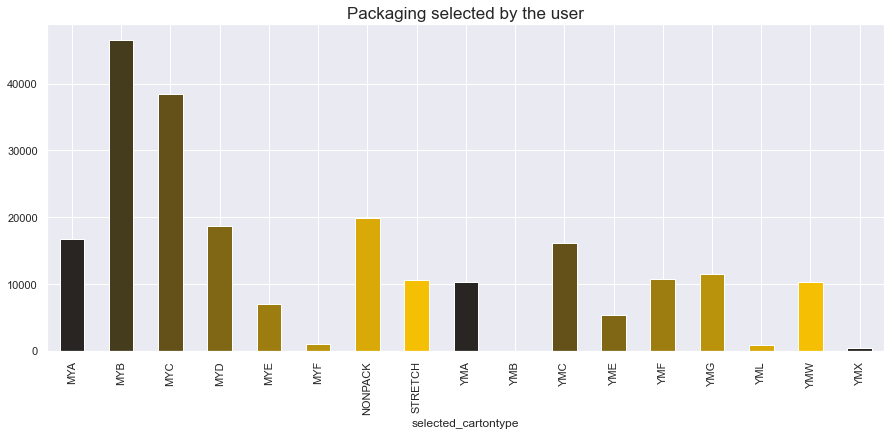

In [28]:
plt.figure(figsize=(15, 6))
data_unity.groupby('selected_cartontype')['orderkey'].count().plot(kind='bar', figsize=(15,6), color=sns.dark_palette("xkcd:golden", 8))
plt.title('Packaging selected by the user', fontsize=(17))
plt.xticks(rotation=90);

In [29]:
data_unity.groupby('orderkey')['selected_cartontype'].apply(lambda x: pd.Series(x).unique()).value_counts().head(10)

[MYB]        39355
[MYC]        28862
[MYA]        14382
[NONPACK]    13365
[MYD]        12761
[STRETCH]     8130
[YMC]         7805
[YMA]         6643
[MYE]         4169
[YMF]         4035
Name: selected_cartontype, dtype: int64

In [30]:
leader_m = ['MYB', 'MYC', 'MYA', 'MYD', 'MYE']
leader_n_s = ['NONPACK', 'STRETCH']
leader_y = ['YMC', 'YMA', 'YMF', 'MYD', 'YMC', 'YMA']

data_unity.query('selected_cartontype in @leader_m')['pack_volume'].value_counts(normalize=True)
data_unity.query('selected_cartontype in @leader_n_s')['pack_volume'].value_counts()
data_unity.query('selected_cartontype in @leader_y')['pack_volume'].value_counts(normalize=True)

3449.6     0.365425
8436.0     0.301799
15580.0    0.147177
999.0      0.130974
26277.3    0.054625
Name: pack_volume, dtype: float64

0.0    30400
Name: pack_volume, dtype: int64

15580.0    0.335104
9000.0     0.288966
13125.0    0.191416
3705.0     0.184514
Name: pack_volume, dtype: float64

Под кодировками MYC, MYA и MYB идёт упаковка в пакеты, она самая популярная при формировании заказа, объём варьируется приблизительно от 1 тыс.см3 до 26 тыс.см3, из чего следует, что более популярны мелкогабаритные товары. По карготипу "NONPACK" и "STRETCH" объём упаковки идёт нулевой, это связано с тем, что товар просто не нуждался в упаковке и стретч-плёнка идёт как расходный материал, который не имеет объёма, таких товаров в данных и нас около 30 тысяч. В коробки аналогично складывают не большие по размеру товары. Теперь посмотрим на данные по рекомендованной упаковке из остовной таблицы:

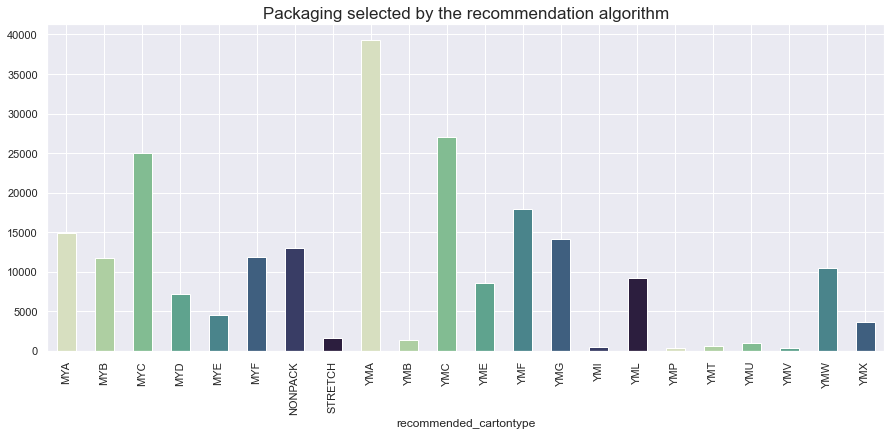

In [31]:
plt.figure(figsize=(15, 6))
data_unity.groupby('recommended_cartontype')['orderkey'].count().plot(kind='bar', figsize=(15,6), color=sns.cubehelix_palette(8,start=.5,rot=-.75))
plt.title('Packaging selected by the recommendation algorithm', fontsize=(17))
plt.xticks(rotation=90);

In [32]:
data_unity.groupby('orderkey')['recommended_cartontype'].apply(lambda x: pd.Series(x).unique()).value_counts().head(10)

[YMA]        30660
[YMC]        17559
[MYC]        16421
[MYA]        13852
[MYF]        10172
[NONPACK]    10050
[MYB]         9690
[YMF]         9344
[YMG]         7066
[YMW]         4858
Name: recommended_cartontype, dtype: int64

Существующий на данный момент алгоритм рекомендательной системы показывает, что необходимо использовать коробки в большем количестве, чем пакеты, что не целесообразно для бизнеса, так как это приведёт к увеличению расходов на упаковку и увеличит расходы бизнеса.

Из приведённых нами графиков стоит отметить, что на данный момент рекомедательный алгоритм рекомендует бо'льшую по стоимости упаковку, что не целесообразно с точки зрения бизнеса, ведёт к увеличение затрат на более дорогую упаковку и росту логистических расходов, связанных с более не рациональным использованием жёсткой упаковки.

## One order - one box <a id='8'>

Рассмотрим заказы, в которых только один товар.

Количество заказов по количеству товаров в них составило:

In [33]:
print('Доля количества  товаров в общем количестве заказов составило: ')

data.groupby('orderkey')['sku'].count().value_counts(normalize=True).head(10)

Доля количества  товаров в общем количестве заказов составило: 


1     0.650735
2     0.166974
3     0.064465
4     0.040160
5     0.023911
6     0.015648
7     0.008100
8     0.006172
10    0.005683
9     0.003768
Name: sku, dtype: float64

Большую часть заказов составляют заказы с одним товаром, поэтому стоит провести более детальный анализ

In [34]:
orders_one_items = data_unity.groupby('orderkey')['sku'].count().reset_index().query('sku==1')['orderkey'].to_list()

# Заказы где box_num имеет только одно уникальное значение                                                                              
orders_one_box = data_unity.groupby('orderkey')['box_num'].nunique().reset_index().query('box_num==1')['orderkey'].to_list()

data_one_goods = data_unity[(data_unity.orderkey.isin(orders_one_items))&(data_unity.orderkey.isin(orders_one_box))]

print('Заказы с одним товарoм составили: ', len(orders_one_items))
print('Заказы которые отправлялись в одной коробке: ', len(orders_one_box))
print('Количество заказов в которых только один товар и которые отправлялись в одной коробке: ', len(data_one_goods))

data_one_goods.sample(5)

Заказы с одним товарoм составили:  115769
Заказы которые отправлялись в одной коробке:  145925
Количество заказов в которых только один товар и которые отправлялись в одной коробке:  115769


,orderkey,selected_cartontype,box_num,recommended_cartontype,sel_calc_cube,recommended_carton,pack_volume,rec_calc_cube,goods_wght,sku,trackingid,a,b,c,sku_volume,price,length,width,height,min_dim,max_dim,min_sku_dim,max_sku_dim
115174,c3962e13dcd1a9133bcf0313143022e9,YMA,1,YMA,4068,YMA,3705.0,4068,0.236,69b4d93910965152168879ff073988c8,0cbc17bc1157da50d55d78c7fc993560,8.8,7.5,17.0,1122.00,4.4,24.7,15.0,10.00,10.00,24.7,7.5,17.0
57639,7b2540105710d9c905a79b0c4d646439,MYA,1,MYA,998,MYA,999.0,998,0.100,b5b65ba8a098f3b386af5a2553352494,3f493c590bb29e761f3803a3ebe67eb9,8.0,2.0,8.0,128.00,1.1,15.0,20.0,3.33,3.33,20.0,2.0,8.0
259118,02826166c84beb15690a77dc8a2ecef0,MYC,1,YMC,8436,YMC,8436.0,8525,0.940,14da387c18840febbfe75fa57ec1d050,75925a42b345779ee25f13e4c725f6ca,20.0,12.0,12.0,2880.00,3.6,30.0,38.0,7.40,7.40,38.0,12.0,20.0
285660,d0e36f552eccad74b312089a3cb860dc,MYC,1,MYC,8436,MYC,8436.0,8436,0.420,bf2895ff676cb3ca8246cda5d09222b9,9ad5f6165e3d45e8ceb6717817094101,19.0,6.5,15.3,1889.55,3.6,30.0,38.0,7.40,7.40,38.0,6.5,19.0
60087,b6328fbe233e2c274ff5bc972d28ed61,MYA,1,MYA,998,MYA,999.0,998,0.006,0b281e43482e300dd709b8abefdba5e6,8382880e2d763b86f93b5224c29d223d,11.0,2.0,13.0,286.00,1.1,15.0,20.0,3.33,3.33,20.0,2.0,13.0


In [35]:
data_one_goods.box_num.value_counts().to_list()

[114619, 943, 132, 32, 18, 6, 4, 3, 3, 2, 2, 1, 1, 1, 1, 1]

Есть заказы где box_num не 1, отбросим их, скорее всего какая-то ошибка выгрузки 

In [36]:
data_one_goods = data_one_goods[data_one_goods.box_num == 1]
data_one_goods.box_num.value_counts().to_list()

[114619]

In [37]:
data_one_goods.selected_cartontype.value_counts(normalize=True).head(7)

MYB        0.300352
MYC        0.200325
MYA        0.114030
NONPACK    0.097104
MYD        0.083834
STRETCH    0.061665
YMA        0.037856
Name: selected_cartontype, dtype: float64

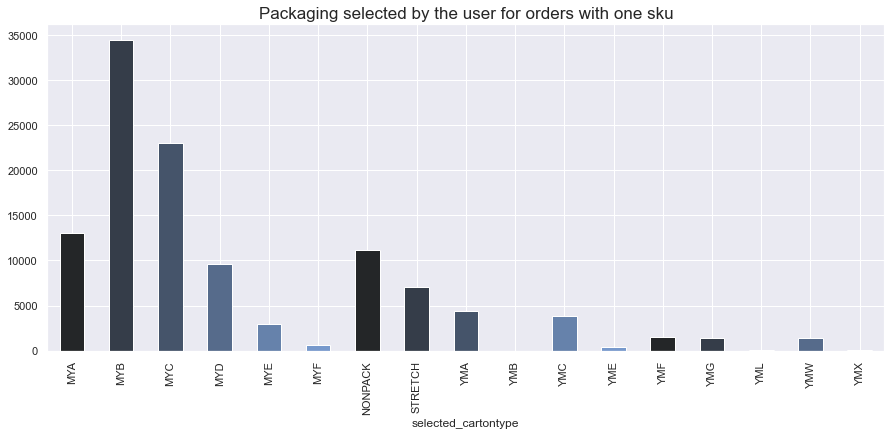

In [38]:
plt.figure(figsize=(15, 6))
data_one_goods.groupby('selected_cartontype')['orderkey'].count().plot(kind='bar', figsize=(15,6), color=sns.dark_palette("#79C"))
plt.title('Packaging selected by the user for orders with one sku', fontsize=(17))
plt.xticks(rotation=90);

Большинство товаров упаковываются в различные по размеру пакеты

Для упрощения условий напишем функцию, которая будет отсортировывать виды упаковок на классы, например, если вид упаковки начинается на на букву 'Y' - это коробки, если на 'М' - пакеты иначе возвращать товары без упаковки или в стретч-плёнке.

In [39]:
def pack_class(carton:str)->str:
    if carton[0] == 'Y':
        return 'box'
    elif carton[0] == 'M':
        return 'package'
    return 'nonpack/stretch'

In [40]:
data_one_goods['pack_class'] = data_one_goods.selected_cartontype.map(pack_class)

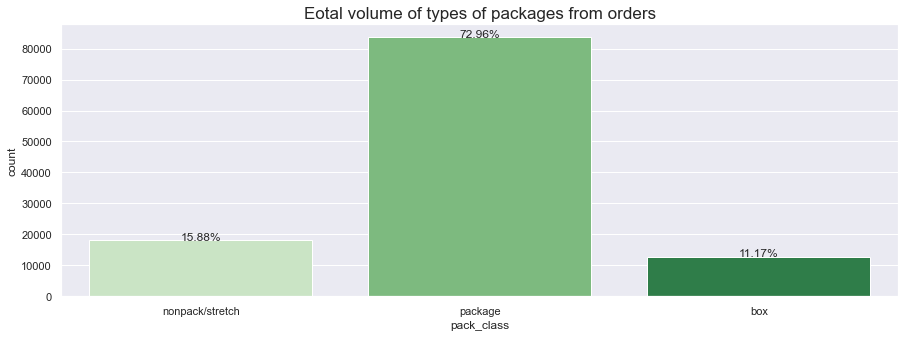

In [41]:
plt.figure(figsize=(15, 5))
ax = sns.countplot(data_one_goods['pack_class'], palette='Greens')
total = float(len(data_one_goods['pack_class']))
for patch in ax.patches:
    height = patch.get_height()
    ax.text(patch.get_x() + patch.get_width() / 2., height + 3, '{:.2f}%'.format((height / total) * 100), ha="center")
    plt.title('Еotal volume of types of packages from orders', fontsize=(17))
plt.show();

Около 73% заказов упаковываются в пакеты, 11% в коробки, а остальные 16% не нуждаются в упаковке, либо упаковываются в стетч-плёнку.

Проанализируем размеры упаковок:

In [42]:
data_one_goods.head(2)

,orderkey,selected_cartontype,box_num,recommended_cartontype,sel_calc_cube,recommended_carton,pack_volume,rec_calc_cube,goods_wght,sku,trackingid,a,b,c,sku_volume,price,length,width,height,min_dim,max_dim,min_sku_dim,max_sku_dim,pack_class
17,4b33fcc98ea1f59d6fe4eb2e0a48bb4b,STRETCH,1,MYD,0,MYD,0.0,15579,0.896,6287a74b664fd8ad4ed5c541b399a82b,6672826678229ee7a3de3b84b905fd59,18.6,3.3,49.7,3050.586,NaN,0.0,0.0,0.0,0.0,0.0,3.3,49.7,nonpack/stretch
18,01277a58f3aa98c06db9046699ec162d,MYE,1,MYD,26277,MYD,26277.3,15579,0.896,6287a74b664fd8ad4ed5c541b399a82b,87b6d2471c093998b982a4c434df8da6,18.6,3.3,49.7,3050.586,8.1,43.0,63.0,9.7,9.7,63.0,3.3,49.7,package


### Dimentions <a id='9'>

Посмотрим графически на взаимосвязь упаковок и товаров.

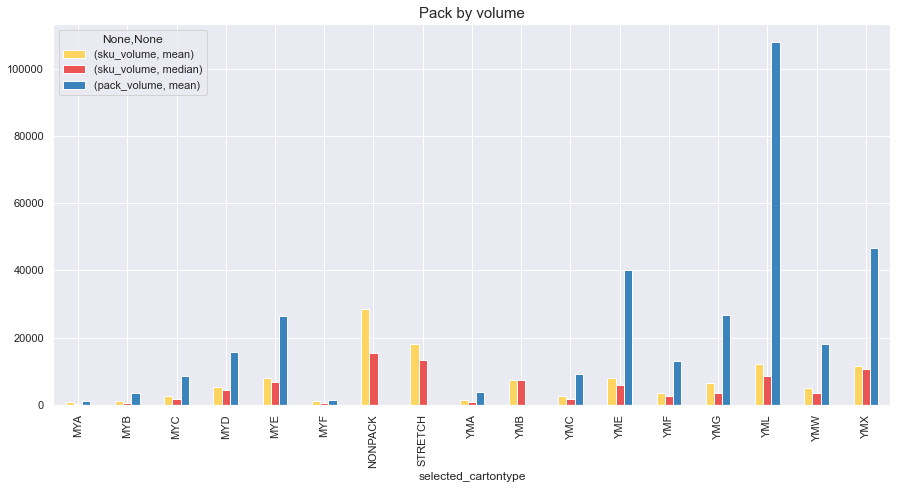

In [43]:
data_one_goods.groupby('selected_cartontype')[['sku_volume', 'pack_volume']]\
              .agg({'sku_volume':['count','mean', 'median'],'pack_volume':'mean'}).round()\
              .drop(('sku_volume', 'count'), axis=1)\
              .plot(kind='bar', figsize=(15, 7), color=['#FFD460', '#EA5455', '#3B83BD'])
plt.title('Pack by volume', fontsize=15);

Объём упаковок по товарам не соответствует выбранному объёму упаковки, существенные различия наблюдаются по коробкам.

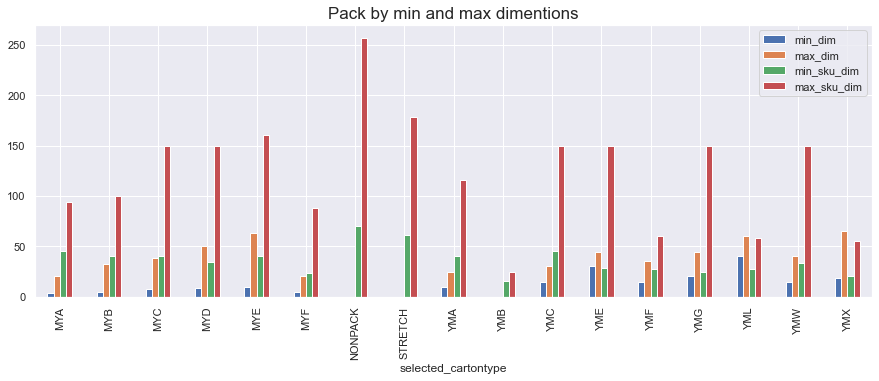

In [44]:
data_one_goods.groupby('selected_cartontype')[['min_dim', 'max_dim', 'min_sku_dim', 'max_sku_dim']]\
            .agg('max').round(2).plot(kind='bar', figsize=(15, 5))

plt.title('Pack by min and max dimentions', fontsize=17);

Размеры товаров превышают размер таких типов упаковок как NONPACK, STRETCH, так как товары по сути ни во что не упаковывались, или стейч идёт как расходный материал и в данных по ним стоят нулевые объёмы их в учёт мы не берём. Стоит обратить внимание, что мы снова видим такие доказательства, что не в зависимости от объёма товара пакеты могут в себя вмещать больший объём, чем их реальный размер. Теперь посмотрим на веса товаров.

### Weights <a id='10'>

In [45]:
data_one_goods.pack_class.value_counts()

package            83621
nonpack/stretch    18198
box                12800
Name: pack_class, dtype: int64

Проведя ранее разделения на классы мы видим, что 83 тыс. заказов были отправлены пакетом, 13 тыс. в коробках и около 18 тыс просто с маркировкой или предварительно завернуты в стретч-плёнку

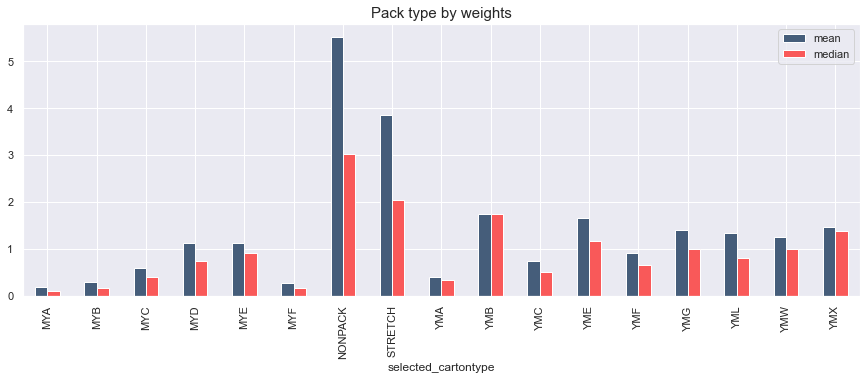

In [46]:
data_one_goods.groupby('selected_cartontype')['goods_wght']\
           .agg(['count', 'mean', 'median'])\
           .drop('count', axis=1)\
           .plot(kind='bar', figsize=(15, 5), color=['#455D7A', '#F95959'])
plt.title('Pack type by weights', fontsize=15);

Средние веса товаров превышают медианное, что говорит о колебании. В упаковку могут положить объем товаров больший, к ним относятся всё те же пакеты. А вот в коробки приблизительно ложат тот объём, который требуется или меньше, так как эта упаковка имеет жёсткость и форму.

### box/package/none <a id='11'>

Теперь посмотрим разницу по весам и объёму в разрезе ранее созданных классов box/package/nonpack,stretch

In [47]:
data_one_goods.groupby('pack_class')[['sku_volume', 'pack_volume']]\
              .agg({'sku_volume':['count','mean', 'median'],'pack_volume':'mean'}).round()

sku_volume                   pack_volume
                     count     mean   median        mean
pack_class                                              
box                  12800   3134.0   1739.0     11906.0
nonpack/stretch      18198  24427.0  14280.0         0.0
package              83621   2176.0    936.0      6607.0

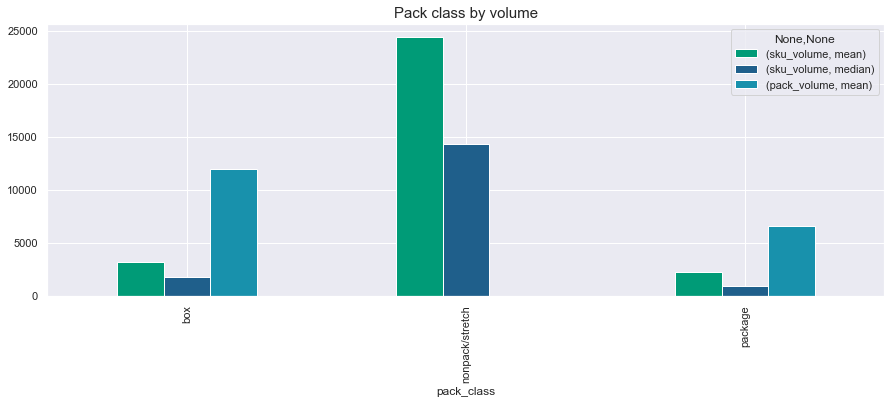

In [48]:
data_one_goods.groupby('pack_class')[['sku_volume', 'pack_volume']]\
              .agg({'sku_volume':['count','mean', 'median'],'pack_volume':'mean'}).round()\
              .drop(( 'sku_volume',  'count'), axis=1).plot(kind='bar', figsize=(15, 5), color=['#009B77', '#1F5F8B', '#1891AC'])
plt.title('Pack class by volume', fontsize=15);

Здесь мы видим, что упаковка используется не оптимально, объём упаковки превышает объём товара.

In [49]:
data_one_goods.groupby('pack_class')[['min_dim', 'max_dim', 'min_sku_dim', 'max_sku_dim']]\
            .agg('mean').round(2)

,min_dim,max_dim,min_sku_dim,max_sku_dim
pack_class,,,,
box,14.36,32.04,8.45,21.10
nonpack/stretch,0.00,0.00,13.63,53.42
package,5.89,34.82,5.88,20.60


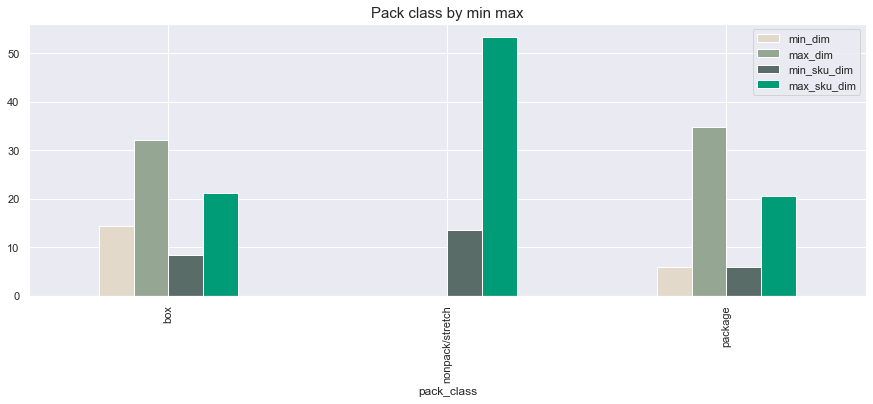

In [50]:
data_one_goods.groupby('pack_class')[['min_dim', 'max_dim', 'min_sku_dim', 'max_sku_dim']]\
              .agg('mean').round(2)\
              .plot(kind='bar', figsize=(15, 5), color=['#E3D9CA', '#95A792', '#596C68', '#009B77'])
plt.title('Pack class by min max', fontsize=15);

Видно, что размеры коробок превышают линейные размеры товаров

In [51]:
data_one_goods.groupby('pack_class')['goods_wght'].agg(['count', 'mean', 'median'])

,count,mean,median
pack_class,,,
box,12800,0.804543,0.500
nonpack/stretch,18198,4.880113,2.600
package,83621,0.479903,0.235


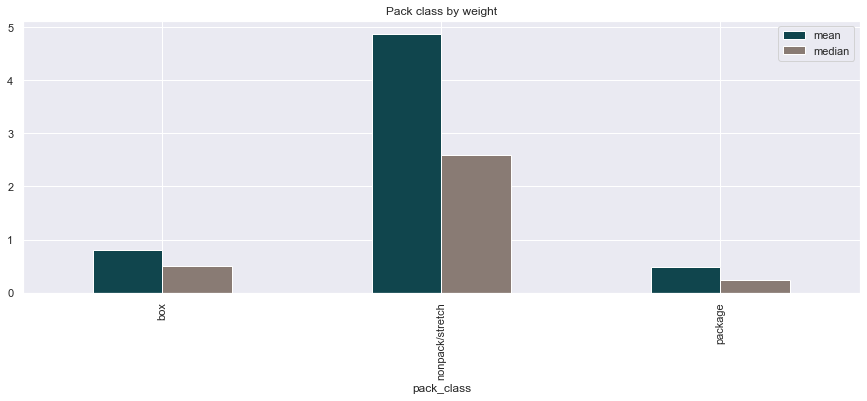

In [52]:
data_one_goods.groupby('pack_class')['goods_wght']\
              .agg(['count', 'mean', 'median'])\
              .drop('count', axis=1).plot(kind='bar', figsize=(15, 5), color=['#10454D', '#897B74'])
plt.title('Pack class by weight');

Средние показатели веса товаров превышают медианное, что говорит нам о том, что в упаковку иногда ложат большие по весу товары, в разработке алгоритма подбора оптимальной упаковки этот момент стоит учитывать. Теперь перейдём к анализу заказов с несколькими товарами.

## one box  - two or three sku <a id='12'>

Заказы с несколькими товарами(2-3) занимают долю около 17% в общем объёме заказов:

In [53]:
orders_few_items = data_unity.groupby('orderkey')['sku'].count().reset_index().query('sku!=1 & sku <4')['orderkey'].to_list()

data_few_goods = data_unity[(data_unity.orderkey.isin(orders_few_items))&(data_unity.orderkey.isin(orders_one_box))]

print('Заказы с 2-3 товарoм составили: ', len(orders_few_items))
print('Заказы которые отправлялись в одной коробке: ', len(orders_one_box))
print('Количество заказов в которых 2-3 товара и которые отправлялись в одной коробке: ', len(data_few_goods))

data_few_goods.sample(5)

Заказы с 2-3 товарoм составили:  28556
Заказы которые отправлялись в одной коробке:  145925
Количество заказов в которых 2-3 товара и которые отправлялись в одной коробке:  55205


,orderkey,selected_cartontype,box_num,recommended_cartontype,sel_calc_cube,recommended_carton,pack_volume,rec_calc_cube,goods_wght,sku,trackingid,a,b,c,sku_volume,price,length,width,height,min_dim,max_dim,min_sku_dim,max_sku_dim
12188,7c05e35128a814ebeb08647e3917b1fa,YMA,1,YMA,4068,YMA,3705.0,4068,1.000,1135a244dc5f3a0132042d140d212375,70401afc5767781795fa836b2248cb67,7.4,14.1,10.7,1116.438,4.4,24.7,15.0,10.0,10.0,24.7,7.4,14.1
70016,512219b339dee6c65ce921b5daa9989d,YMF,1,YMF,13500,YMF,13125.0,13500,0.175,0439b2af8ae0db0447d63d9444dd0192,06de1f76b5e853ba90a81a428bd2cdec,18.0,4.0,5.0,360.000,10.7,35.0,25.0,15.0,15.0,35.0,4.0,18.0
209643,f96c44d21f01374fdee635b6e36b4e9a,MYD,1,YMF,15579,YMF,15580.0,13125,0.525,f75c573fd66c4cf164e43fcaa439fb6d,008dd89a894de67556c02d70c8f7426b,4.4,30.0,17.0,2244.000,6.9,38.0,50.0,8.2,8.2,50.0,4.4,30.0
39399,7750dd33fd8106271bd2550813ea5b95,YMC,1,YMF,9000,YMF,9000.0,13125,0.740,aa03cffa2f5c26943b414227e589718e,5b431a6f30e70dde2209c8d9bb6b5d10,29.0,14.0,16.0,6496.000,7.8,30.0,20.0,15.0,15.0,30.0,14.0,29.0
148527,2b158e38b862dcee9117fa376ac22c46,MYB,1,YMA,3449,YMA,3449.6,3705,0.050,40f2c385bf89b666eed60d3da3178ad7,38270838da16bd8d60ca2d9f5b4d25f9,9.0,1.0,7.0,63.000,2.3,22.0,32.0,4.9,4.9,32.0,1.0,9.0


Дополнительно проверим условие, для того, чтобы в выборке у нас остались только те товары, которые упаковывались в одну коробку

In [54]:
data_few_goods = data_few_goods[data_few_goods.box_num == 1]
print('Количество уникальных значений в box_num составило: ', data_few_goods.box_num.value_counts())

Количество уникальных значений в box_num составило:  1    54500
Name: box_num, dtype: int64


In [55]:
data_few_goods.selected_cartontype.value_counts().head(7)

MYC    11378
MYB     9522
YMC     7146
MYD     5570
YMA     4481
YMF     3993
YMW     3252
Name: selected_cartontype, dtype: int64

Посмотрим графически на типы упаковок для заказов и с помощью ранее созданной функции посмотрим на заказы в разрезе трёх типов упаковок:

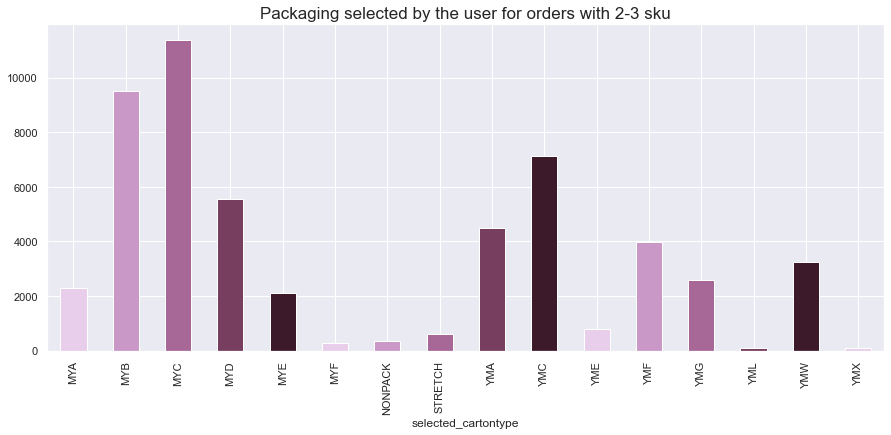

In [56]:
plt.figure(figsize=(15, 6))
data_few_goods.groupby('selected_cartontype')['orderkey'].count().plot(kind='bar', figsize=(15,6), color=sns.cubehelix_palette(5,start=.75,rot= -.150))
plt.title('Packaging selected by the user for orders with 2-3 sku', fontsize=(17))
plt.xticks(rotation=90);

In [57]:
data_few_goods['pack_class'] = data_few_goods.selected_cartontype.map(pack_class)

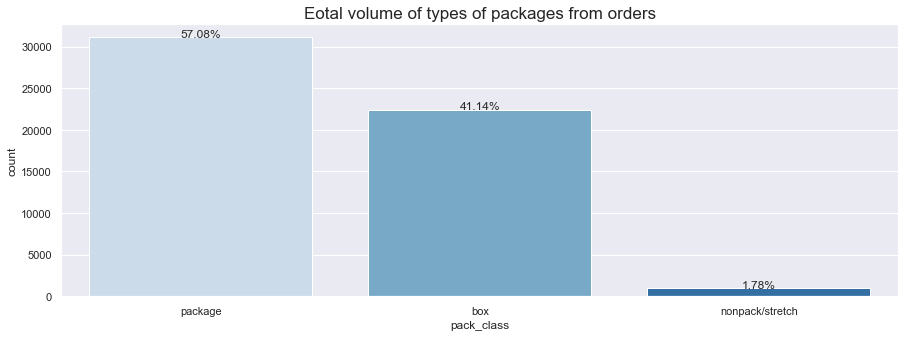

In [58]:
plt.figure(figsize=(15, 5))
ax = sns.countplot(data_few_goods['pack_class'], palette='Blues')
total = float(len(data_few_goods['pack_class']))
for patch in ax.patches:
    height = patch.get_height()
    ax.text(patch.get_x() + patch.get_width() / 2., height + 3, '{:.2f}%'.format((height / total) * 100), ha="center")
    plt.title('Еotal volume of types of packages from orders', fontsize=(17))
plt.show();

В заказах по нескольким товарам на первом месте по упаковочному материалу стоят пакеты, однако в них уже более часто используют коробки (около 41%) в сравнении с заказами с одним товаром, возможно это связано с тем, чтобы заказ до покупателя дошёл в единой упаковке, но посмотрим на карготипы этих товаров, чтобы понять с чем это связано.

In [59]:
data_few_goods

,orderkey,selected_cartontype,box_num,recommended_cartontype,sel_calc_cube,recommended_carton,pack_volume,rec_calc_cube,goods_wght,sku,trackingid,a,b,c,sku_volume,price,length,width,height,min_dim,max_dim,min_sku_dim,max_sku_dim,pack_class
20,e14e21fd406ff6774e69660a492a932a,MYE,1,MYD,26277,MYD,26277.3,15579,0.896,6287a74b664fd8ad4ed5c541b399a82b,a1007b3c6a0fec5af3732b0f0db782b1,18.6,3.3,49.7,3050.586,8.1,43.0,63.0,9.7,9.7,63.0,3.3,49.7,package
30,1154ced11d6437a5dfea2faa3f4a6f72,YMG,1,YME,26820,YME,26820.0,40050,0.700,d714bc5c946ec01d9b09714524805e5c,6cdfda14953f69b681966bec7d15a6c0,14.0,10.7,43.8,6561.240,17.5,44.7,30.0,20.0,20.0,44.7,10.7,43.8,box
34,cf766b2bd15b2d15d21da56375dae33a,YMW,1,YMF,18000,YMF,18000.0,13125,2.078,eb0e661f3ed57ef7ca16418bf50e363e,957e7f54438771b44eb37ed039b48ff5,23.4,8.0,33.9,6346.080,13.9,40.0,30.0,15.0,15.0,40.0,8.0,33.9,box
59,dfa1ef503601208977922acad777cdcd,YMG,1,YMW,26820,YMW,26820.0,18000,2.078,eb0e661f3ed57ef7ca16418bf50e363e,a7d31017db10fc1de10a74a78b73e22c,23.4,8.0,33.9,6346.080,17.5,44.7,30.0,20.0,20.0,44.7,8.0,33.9,box
63,8b8248a2807c9faa987db6f03ae5d205,YMG,1,YMG,26820,YMG,26820.0,26820,2.078,eb0e661f3ed57ef7ca16418bf50e363e,ebeb7bb123c0fe048ff8cb15392af75a,23.4,8.0,33.9,6346.080,17.5,44.7,30.0,20.0,20.0,44.7,8.0,33.9,box
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314649,5b6b03ffea4a8fbdc2a2b73d5e921f0a,MYD,1,YMU,7600,YMU,15580.0,2592,0.260,b468575d3877fa142dad72f2d18aacff,7e89ada050fd12d3e06c0751a5ba3de9,21.0,2.0,18.0,756.000,6.9,38.0,50.0,8.2,8.2,50.0,2.0,21.0,package
314650,5b6b03ffea4a8fbdc2a2b73d5e921f0a,MYD,1,YMU,7600,YMU,15580.0,2592,0.260,03e2e19b4ad122361b7469dcf7f9a2a7,7e89ada050fd12d3e06c0751a5ba3de9,21.0,3.0,18.0,1134.000,6.9,38.0,50.0,8.2,8.2,50.0,3.0,21.0,package
314658,287d07fac19f4997ad20efe35905d36f,YMW,1,YMG,21812,YMG,18000.0,18270,0.080,51e874abc87c5a096c55ac5558f1f929,403e365d84e87ab19bfa6f8677123b30,8.0,12.0,12.0,1152.000,13.9,40.0,30.0,15.0,15.0,40.0,8.0,12.0,box
314676,47dbb5d2b2dbeb7a8017f7656517e2c9,YMG,1,YMW,18270,YMW,26820.0,21812,0.550,2a7f6883fadf6fa7a2306376e598b56c,05466bb9687134041a318a1578e9101e,18.0,6.0,18.0,1944.000,17.5,44.7,30.0,20.0,20.0,44.7,6.0,18.0,box


Посмотрим на товары в разрезе типов упаковок, пакетов и коробок

In [60]:
sku_list_package = data_few_goods.query("pack_class == 'package'")['sku'].unique().tolist()
sku_list_box = data_few_goods.query("pack_class == 'box'")['sku'].unique().tolist()

cargotype_few_package = sku_cargotypes.query('sku in @sku_list_package').merge(cargotype_info, on='cargotype', how='inner')
cargotype_few_box = sku_cargotypes.query('sku in @sku_list_box').merge(cargotype_info, on='cargotype', how='inner')

cargotype_few_package.sample(5)
cargotype_few_box.sample(5)

,sku,cargotype,description
52124,186db0f46218a838cc2937167740a962,440,товары для красоты
22482,dcc1d23a6dbf866e6821a6303d56f0fb,290,малогабаритный товар
31698,2cc1a45da78f43fb455143efb3bbdcf0,290,малогабаритный товар
40216,58c34b367b8019612a48a7ddbf26bb02,410,опасный Авиа
9403,c0e14d0143a9db7f94634ce0e9152eda,290,Склад МГТ (малогабаритный товар)


,sku,cargotype,description
30429,4627a26542aa780961691e299c0738dc,340,не требует упаковки
5616,e0760fbc2ec904ae89df9e2ec92d6d99,290,малогабаритный товар
26772,4e9d68682ce594b6202bdec1d98d0224,320,сыпучее
19800,7f068a1e24b9b8cb4827cf9246139f98,290,малогабаритный товар
7914,601cb3c8a205f31ebedd2354b46dda94,290,малогабаритный товар


In [61]:
print('Количество товаров, которые были упакованы в пакеты: ', len(cargotype_few_package))
print('Количество товаров, которые были упакованы в пакеты: ', len(cargotype_few_box))

Количество товаров, которые были упакованы в пакеты:  90484
Количество товаров, которые были упакованы в пакеты:  62843


In [62]:
cargotype_few_package.groupby('sku')['description'].apply(list).value_counts().head(10)

[малогабаритный товар, Склад МГТ (малогабаритный товар)]                                                                                                               5143
[малогабаритный товар, Склад МГТ (малогабаритный товар), опасный Авиа]                                                                                                 1135
[малогабаритный товар, Склад МГТ (малогабаритный товар), влажный (мокрый), пачкается, пачкает, впитывает запах]                                                         939
[малогабаритный товар, Склад МГТ (малогабаритный товар), влажный (мокрый), пачкается, пачкает]                                                                          869
[малогабаритный товар, Склад МГТ (малогабаритный товар), не требует упаковки]                                                                                           694
[малогабаритный товар, Склад МГТ (малогабаритный товар), опасный Авиа, сыпучее]                                                             

In [63]:
cargotype_few_box.groupby('sku')['description'].apply(list).value_counts().head(10)

[малогабаритный товар, Склад МГТ (малогабаритный товар)]                                                                                                               2227
[малогабаритный товар, Склад МГТ (малогабаритный товар), опасный Авиа]                                                                                                  858
[малогабаритный товар, Склад МГТ (малогабаритный товар), сыпучее, опасный Авиа]                                                                                         625
[малогабаритный товар, Склад МГТ (малогабаритный товар), не требует упаковки]                                                                                           554
[малогабаритный товар, Склад МГТ (малогабаритный товар), опасный Авиа, мнется]                                                                                          496
[малогабаритный товар, Склад МГТ (малогабаритный товар), не требует упаковки, опасный Авиа]                                                 

В большей части это малогабаритные товары с низкой стоимостью, предполагаем, что это продукты, бытовая химия, мелкая электроника либо одежда. Карготипы проставляются в зависимости от характеристик товаров в заказе, поэтому мы можем только сделать предположение о том, что товары в заказе формируют от решения сотрудника.

Проведём более детальный анализ тех же моментов, что и по заказам с одним товаром

### Dimentions <a id='13'>

Посмотрим графически на взаимосвязь упаковок и товаров.

In [64]:
data_few_goods.groupby('selected_cartontype')[['sku_volume', 'pack_volume']]\
              .agg({'sku_volume':['count','mean', 'median'],'pack_volume':'mean'}).round()

sku_volume                 pack_volume
                         count    mean  median        mean
selected_cartontype                                       
MYA                       2278  1020.0   342.0       999.0
MYB                       9522   704.0   420.0      3450.0
MYC                      11378  1253.0   807.0      8436.0
MYD                       5570  2350.0  1575.0     15580.0
MYE                       2094  3558.0  2249.0     26277.0
MYF                        267   393.0   291.0      1500.0
NONPACK                    369  3737.0  1862.0         0.0
STRETCH                    601  6835.0  5423.0         0.0
YMA                       4481   814.0   575.0      3705.0
YMC                       7146  1497.0  1120.0      9000.0
YME                        779  6060.0  4190.0     40050.0
YMF                       3993  2289.0  1573.0     13125.0
YMG                       2575  4525.0  3134.0     26820.0
YML                        110  7063.0  3364.0    108000.0
YMW                       3252  3362.0  2298.0     18000.0
YMX                         85  7794.0  4190.0     46800.0

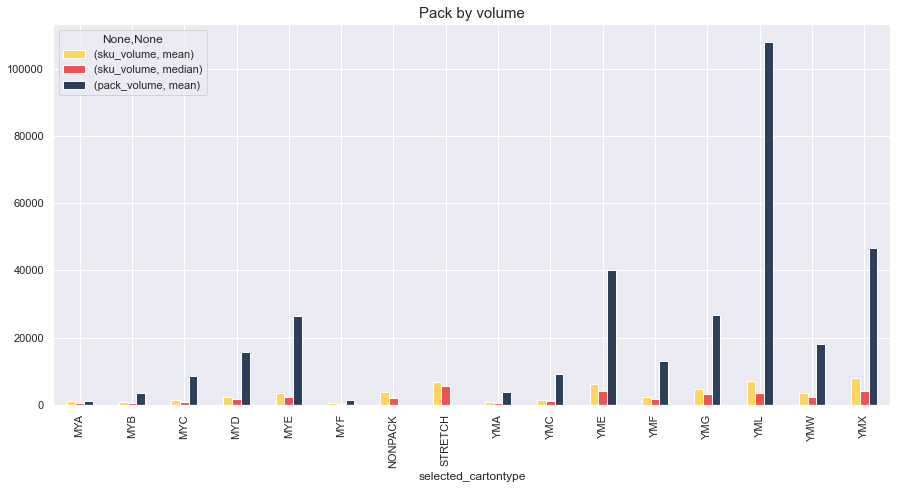

In [65]:
data_few_goods.groupby('selected_cartontype')[['sku_volume', 'pack_volume']]\
              .agg({'sku_volume':['count','mean', 'median'],'pack_volume':'mean'}).round()\
              .drop(('sku_volume', 'count'), axis=1)\
              .plot(kind='bar', figsize=(15, 7), color=['#FFD460', '#EA5455', '#2D4059'])
plt.title('Pack by volume', fontsize=15);

Объём упаковок исподьзуется не оптимально

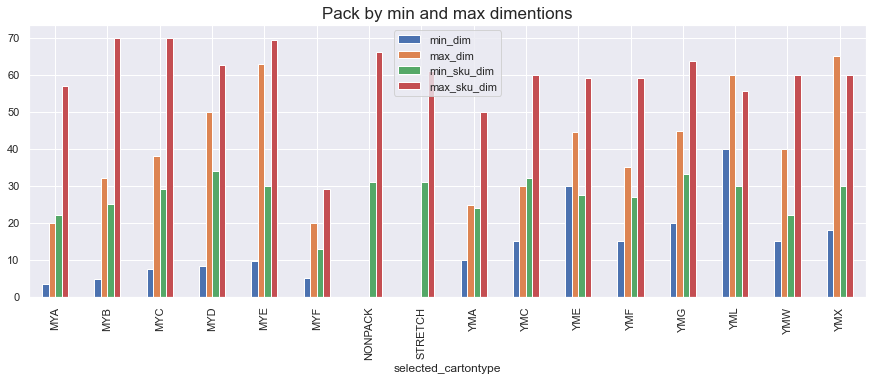

In [66]:
data_few_goods.groupby('selected_cartontype')[['min_dim', 'max_dim', 'min_sku_dim', 'max_sku_dim']]\
            .agg('max').round(2).plot(kind='bar', figsize=(15, 5))
plt.title('Pack by min and max dimentions', fontsize=17);

Размеры товаров превышают размер  упаковок, также как и по заказам с одним товаром.

### Weights <a id='14'>

In [67]:
data_few_goods.pack_class.value_counts()

package            31109
box                22421
nonpack/stretch      970
Name: pack_class, dtype: int64

В данных заказах 31 тыс. заказов были отправлены пакетом, 22 тыс. в коробках и около 970 просто с маркировкой или предварительно завернуты в стретч-плёнку

In [68]:
data_few_goods.groupby('selected_cartontype')['goods_wght']\
           .agg(['count', 'mean', 'median'])

,count,mean,median
selected_cartontype,,,
MYA,2278,0.240633,0.100
MYB,9522,0.183361,0.107
MYC,11378,0.310255,0.200
MYD,5570,0.502911,0.300
MYE,2094,0.632873,0.400
MYF,267,0.140655,0.100
NONPACK,369,0.689447,0.400
STRETCH,601,1.194557,0.794
YMA,4481,0.261025,0.200


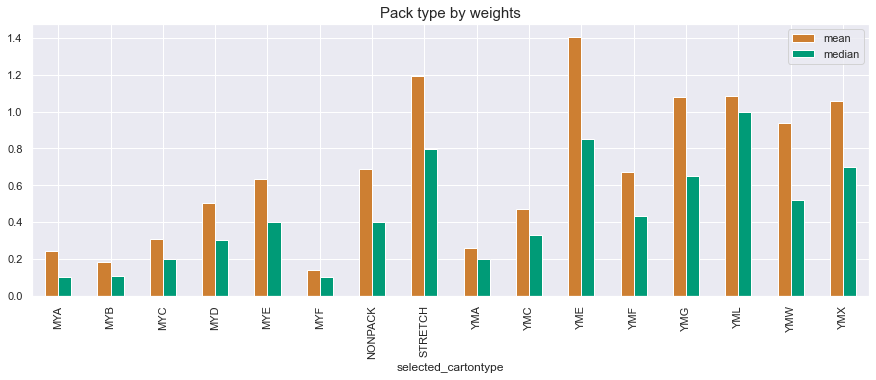

In [69]:
data_few_goods.groupby('selected_cartontype')['goods_wght']\
           .agg(['count', 'mean', 'median'])\
           .drop('count', axis=1)\
           .plot(kind='bar', figsize=(15, 5), color=['#CD7F32', '#009B77'])
plt.title('Pack type by weights', fontsize=15);

По данным графика наблюдается разница между средними и медианными показателями. Наиболее сильные отличия видны по коробке типа YME, YMW и YMX, постоянно в них фигурируют разные по весу товары.

### box/package/none <a id='15'>

In [70]:
data_few_goods.groupby('pack_class')[['sku_volume', 'pack_volume']]\
              .agg({'sku_volume':['count','mean', 'median'],'pack_volume':'mean'}).round()

sku_volume                 pack_volume
                     count    mean  median        mean
pack_class                                            
box                  22421  2329.0  1260.0     13736.0
nonpack/stretch        970  5656.0  3933.0         0.0
package              31109  1412.0   704.0      8786.0

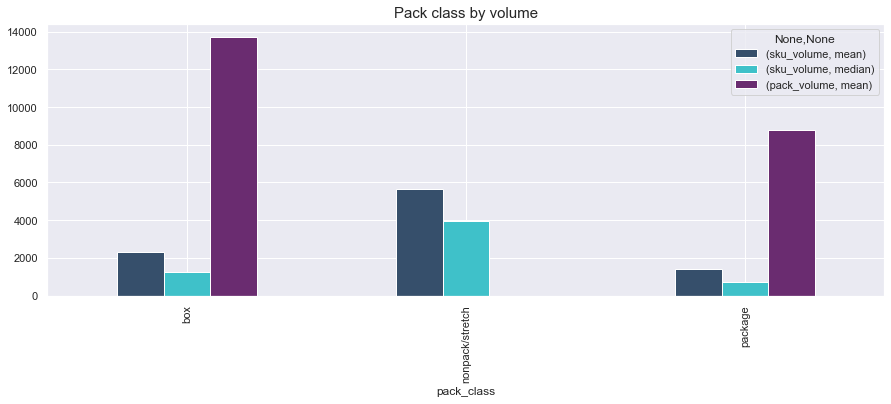

In [71]:
data_few_goods.groupby('pack_class')[['sku_volume', 'pack_volume']]\
              .agg({'sku_volume':['count','mean', 'median'],'pack_volume':'mean'}).round()\
              .drop(( 'sku_volume',  'count'), axis=1).plot(kind='bar', figsize=(15, 5), color=['#364F6B', '#3FC1C9', '#6A2C70'])
plt.title('Pack class by volume', fontsize=15);

Наибольшая разница в объёме упаковок наблюдается по типам с коробками, чем с пакетами, объём коробок сильно превышает объём товаров.

In [72]:
data_few_goods.groupby('pack_class')[['min_dim', 'max_dim', 'min_sku_dim', 'max_sku_dim']]\
            .agg('mean').round(2)

,min_dim,max_dim,min_sku_dim,max_sku_dim
pack_class,,,,
box,15.23,33.75,6.93,20.58
nonpack/stretch,0.00,0.00,8.43,27.92
package,6.61,38.52,5.09,19.24


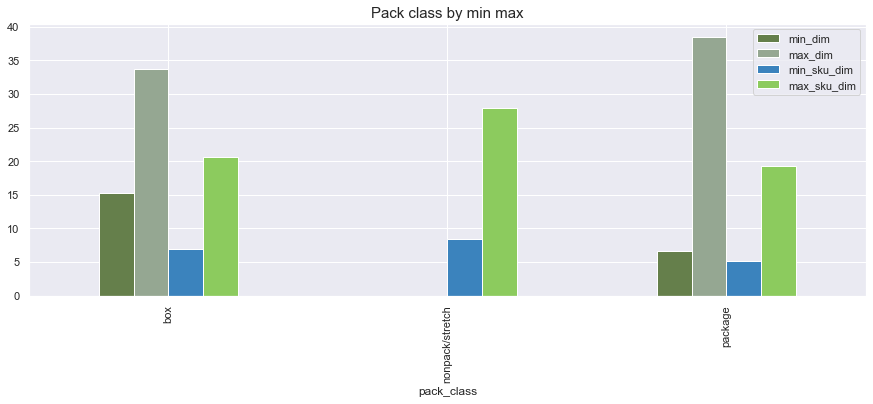

In [73]:
data_few_goods.groupby('pack_class')[['min_dim', 'max_dim', 'min_sku_dim', 'max_sku_dim']]\
              .agg('mean').round(2)\
              .plot(kind='bar', figsize=(15, 5), color=['#657F4B', '#95A792', '#3B83BD', '#8CCB5E'])
plt.title('Pack class by min max', fontsize=15);

размеры коробок превышают линейные размеры товаров

In [74]:
data_few_goods.groupby('pack_class')['goods_wght'].agg(['count', 'mean', 'median'])

,count,mean,median
pack_class,,,
box,22421,0.640164,0.365
nonpack/stretch,970,1.002407,0.600
package,31109,0.321071,0.188


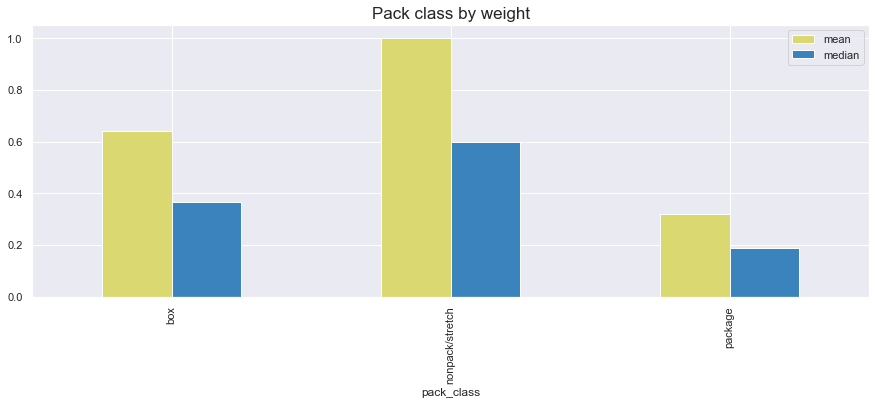

In [75]:
data_few_goods.groupby('pack_class')['goods_wght']\
              .agg(['count', 'mean', 'median'])\
              .drop('count', axis=1).plot(kind='bar', figsize=(15, 5), color=['#DAD871', '#3B83BD'])
plt.title('Pack class by weight', fontsize=(17));

Эти визуализации по товарам показали,что упаковка используется не оптимальным образом. 

## Вывод:  <a id='16'>

Нам были предоставлены  7 файлов содержащие как основную информацию о заказах, так и необходимые характиристики для дальнейшего анализа показателей.

Данным не потребовалось дополнительной обработки, типы данных соответстствуют содержанию столбцов. В анализе мы брали только те товары, по которым у нас была информация в основной таблице, рассчитали на основании слияния таблиц дополнительные признаки, такие как: объём товара, объём упаковки, минимальную и максимальную сторону товара используя их линейные размеры и минимальную, максимальную сторону упаковок соответственно.

В основном датасете у нас были товары с нулевыми весами в заказах, для проверки, мы вывели их характеристики с помощью таблицы "sku" и приняли решение их удалить.

Визуализация показала, что самая популярная при формировании заказа упаковка - это пакеты, объём варьируется приблизительно от 1 тыс.см3 до 26 тыс.см3, из чего следует, что более популярны мелкогабаритные товары. По карготипу "NONPACK" и "STRETCH" объём упаковки идёт нулевой, это связано с тем, что товар просто не нуждался в упаковке и стретч-плёнка идёт как расходный материал, который не имеет объёма, таких товаров в данных и нас около 30 тысяч. В коробки аналогично складывают не большие по размеру товары.

Существующий на данный момент алгоритм рекомендательной системы предлагает использовать коробки в большем количестве, чем пакеты, что не целесообразно для бизнеса, так как это приведёт к увеличению расходов на упаковку и увеличит логистические расходы связанные с более не рациональным использованием по объёму упаковки.

Далее мы разделили заказы на две основные группы, доля которых была существенной в общем объёме заказов:
 - заказы с одним товаром
 - заказы с несколькими заказами
 

В заказах с одним товаром около 73% заказов упаковываются в пакеты, 11% в коробки, а остальные 16% не нуждаются в упаковке, либо упаковываются в стетч-плёнку, по заказам с несколькими товарами немного другой разброс, на первом месте по упаковочному материалу стоят пакеты, однако в них уже более часто используют коробки (около 41%). Чтобы понять причину использования коробок, мы с помощью таблицы с описанием карготипов вывели характеристики товаров и пришли к выводу, что карготипы товаров проставляются в зависимости от характеристик товаров. Причину большего количества коробок мы не знаем, но предполагаем, что они выбираются по усмотрению сотрудника. 

Визуализация по двум выборкам схожа между собой и мы делаем обобщающий вывод о том, что:
 - размеры упаковок, превышают размеры товаров, особенно это видно по коробкам
 - объём упаковок выше, чем объём занимаемый товарами
 - средний и медианный вес товаров в упаковках различный
 
 Исходя из анализа следует, что для улучшения способа подбора и рекомендации пользователю наиболее выгодной для бизнеса упаковки, с учётом веса, объемов и иных характеристик необходимо разработать ML алгоритм .